## 1、Name 分类

使用GRU模型

In [7]:
# 1、准备数据
import torch
import gzip,csv,time,math
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import numpy as np
import matplotlib.pyplot as plt


class NameDataset(Dataset):
    def __init__(self,is_train_set=True):
        filename = './data/names_train.csv.gz' if is_train_set else './data/names_test.csv.gz'
        # 读取压缩类型为gz的csv文件
        with gzip.open(filename,'rt') as f:
            reader = csv.reader(f)
            rows = list(reader)
        
        # 提取name
        self.names = [row[0] for row in rows]
        # 提取len
        self.len = len(self.names)
        # 提取country
        self.countries = [row[1] for row in rows]
        # 去重得到country_list和dict 
        self.country_list = list(sorted(set(self.countries)))
        self.country_dict = self.getCountryDict()
        # 提取country的num
        self.country_num = len(self.country_list)
    
    def __getitem__(self, index):
        # 先拿出来国家countries[index],然后再通过字典取到对应的索引值。
        return self.names[index],self.country_dict[self.countries[index]]
    
    def __len__(self):
        return self.len
    
    # 得到国家的name和数字索引字典
    def getCountryDict(self):
        country_dict = {}
        for idx, country_name in enumerate(self.country_list,0):
            country_dict[country_name] = idx
        return country_dict
    # idx索引转国家
    def idx2country(self,idx):
        return self.country_list[idx]
    # 获取国家的num
    def getCountryNum(self):
        return self.country_num
# 超参数
# 隐藏层的size
HIDDEN_SIZE = 100
BATCH_SIZE = 256
# 层数
N_LAYER = 2
N_EPOCHS = 100
N_CHARS = 128
# 是否使用gpu
# USE_GPU = False # 8min
USE_GPU = True
 
# 训练集和测试集
train_dataset = NameDataset(is_train_set=True)
test_dataset = NameDataset(is_train_set=False)
trainloader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
testloader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)
# 国家总数
N_COUNTRY = train_dataset.getCountryNum()


In [ ]:
# 2、设计模型
class RNNClassifier(torch.nn.Module):
    def __init__(self,input_size,hidden_size,output_size,n_layers=1,bidirection=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.n_directions = 2 if bidirection else 1
        # 嵌入层
        # 使用Embedding层将输入的字符索引转换为稠密向量，
        # 输入形状是(seq_len ,batch_size),输出形状是(seq_len, batch_size, hidden_size)
        self.embedding = torch.nn.Embedding(self.input_size,self.hidden_size)
        # 定义GRU层
        # gru层的输入特征数是hidden_size,输出也是hidden_size，层数是n_layers,bidirectional参数是是否双向
        self.gru = torch.nn.GRU(self.hidden_size,self.hidden_size,self.n_layers,bidirectional=bidirection)
        self.fc = torch.nn.Linear(self.hidden_size * self.n_directions,self.output_size)

    def _init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size)
        return create_tensor(hidden)
    
    def forward(self,input,seq_lengths):
        # input shape: (batch_size, seq_len) -> (seq_len, batch_size)
        # RNN 通常要求输入形状为 (seq_len, batch_size, input_size)
        # .t() 方法仅适用于二维张量（矩阵）
        # 高维张量转置
        # input = input.transpose(0, 1)
        # input = input.permute(1, 0)

        input = input.t()
        batch_size = input.size(1)
        
        # h0: (num_layers * num_directions, batch_size, hidden_size)

        hidden = self._init_hidden(batch_size)
        # 嵌入层
        # 嵌入层
        # 输入：(seq_len, batch_size)
        # 输出：(seq_len, batch_size, hidden_size)
        embedding = self.embedding(input)

        # 打包-RNN计算时会自动跳过填充部分，提高效率
        # # pack_padded_sequence(): 将填充后的序列压缩成紧凑格式,
        # pad_packed_sequence(): 将压缩序列恢复为填充格式
        # input:
        # embedding: (seq_len, batch_size, hidden_size)
        # seq_lengths:是每个序列的长度，用于指定每个序列的有效长度。
        # 输出：
        # packed_embedding: (seq_len, batch_size, hidden_size)
        gru_input = pack_padded_sequence(embedding, seq_lengths.cpu())
        # GRU层
        # 输入：
        # input: (seq_len, batch_size, hidden_size)
        # hidden: (num_layers * num_directions, batch_size, hidden_size)
        # 输出：
        # output: (seq_len, batch_size, hidden_size * num_directions)
        # hidden: (num_layers * num_directions, batch_size, hidden_size)
        output,hidden = self.gru(gru_input,hidden)

        # 双向的需要拼接？？
        if self.n_directions == 2:
            hidden_cat = torch.cat([hidden[-1],hidden[-2]],dim = 1)
        else:
            hidden_cat = hidden[-1]
        fc_output = self.fc(hidden_cat)
        return fc_output
def name2list(name):
    # ord() 函数返回字符的 Unicode 编码 如 ord('a') = 97
    # chr() 函数返回 Unicode 编码对应的字符 如 chr(97) = 'a'
    arr = [ord(c) for c in name]
    return arr,len(arr)

def make_tensors(names,countries):
    # 名字转字母的ascii码序列
    # sequences_and_lengths: 每个name转换为arr,len(arr)
    # 维度是 (batch_size, 元组 (name, name_len))
    sequences_and_lengths = [name2list(name) for name in names]
    # 每个name的ascii码序列
    name_sequences = [sl[0] for sl in sequences_and_lengths]
    # 每个name的长度
    seq_lengths = torch.tensor([sl[1] for sl in sequences_and_lengths],dtype=torch.long)
    # 转换为long类型
    countries = countries.long()

    # make tensor of name: (batch_size,seq_len)
    
    seq_tensor = torch.zeros(len(name_sequences),seq_lengths.max()).long()
    for idx,(seq,seq_len) in enumerate(zip(name_sequences,seq_lengths),0):
            # 填充到最大长度，不足的部分用0填充
            seq_tensor[idx,:seq_len] = torch.tensor(seq)
            # seq_tensor[idx,:seq_len] = torch.tensor(seq,dtype=torch.long)


    # 按照序列长度降序排列,然后打包作为RNN的输入
    # seq_lengths是一个一维张量,包含了每个序列的长度
    # 排序后的索引
    seq_lengths, perm_idx = seq_lengths.sort(dim=0,descending=True)
    seq_tensor = seq_tensor[perm_idx]
    countries = countries[perm_idx]
    return create_tensor(seq_tensor),create_tensor(seq_lengths),create_tensor(countries)

# 转换为cuda张量
def create_tensor(tensor):
    
    if USE_GPU:
        device = torch.device("cuda:0")
        tensor = tensor.to(device)
    return tensor

# 计算程序运行的时间
def time_since(since): 
    s = time.time() - since
    m = math.floor( s / 60)
    s -= m * 60 
    # 运行分钟和秒数

    return f'{m}m {s}s'

def trainModel():
    total_loss = 0
    # start_index = 1 ?
    for i,(names,countries) in enumerate(trainloader,1):
        # 转换为张量
        inputs, seq_lengths,target = make_tensors(names,countries)
        output = classifier(inputs,seq_lengths)
        loss = criterion(output,target)
        # 梯度清零
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()

        total_loss += loss.item()
        if i % 30 == 0:
            # 时间，当前epoch
            print(f'[{time_since(start)}] Epoch {epoch}', end = '')
            # 目前train的训练集的百分比
            print(f'[{i * len(inputs)} / {len(train_dataset)}]', end = '')
            # 目前的平均损失
            print(f'loss = {total_loss / (i * len(inputs))}')
    return total_loss

def testModel():
    correct = 0
    total = len(test_dataset)
    print('evaluating trained model ...')

    with torch.no_grad():
        for i, (names,countries) in enumerate(testloader,1):
            inputs,seq_lengths,target = make_tensors(names,countries)
            # RuntimeError: 'lengths' argument should be a 1D CPU int64 tensor, but got 1D cuda:0 Long tensor 
            # 错误说明： PyTorch 的 pack_padded_sequence 等 RNN 工具函数强制要求序列长度张量（lengths）
            # 必须是 CPU 上的 int64 类型，但你的代码中将其放到了 GPU 上（cuda:0）。
            output = classifier(inputs,seq_lengths)
            pred = output.max(dim=1,keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        percent = 100 * correct / total
        print(f'Test set: Accuray {correct} / {total} = {percent:.2f}%')
        return correct / total


In [9]:
# rnn 分类器对象

classifier = RNNClassifier(input_size=N_CHARS,hidden_size=HIDDEN_SIZE,output_size=N_COUNTRY,n_layers=N_LAYER)
if USE_GPU:
    device = torch.device("cuda:0")
    classifier.to(device)

# 损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(),lr = 0.001)

start = time.time()

print(f'Training for {N_EPOCHS} epochs...')
acc_list = []

for epoch in range(1,N_EPOCHS + 1):
    # Train cycle
    trainModel()
    acc = testModel()
    acc_list.append(acc)


Training for 100 epochs...
 1.6055271625518799s] Epoch 1[7680 / 13374]loss = 0.006873257830739022
evaluating trained model ...
Test set: Accuray 4488 / 6700 = 66.99%
 3.548886299133301s] Epoch 2[7680 / 13374]loss = 0.003984453622251749
evaluating trained model ...
Test set: Accuray 4943 / 6700 = 73.78%
 5.690262317657471s] Epoch 3[7680 / 13374]loss = 0.0030982389270017546
evaluating trained model ...
Test set: Accuray 5224 / 6700 = 77.97%
 7.677190542221069s] Epoch 4[7680 / 13374]loss = 0.0026297486076752347
evaluating trained model ...
Test set: Accuray 5384 / 6700 = 80.36%
 9.520174980163574s] Epoch 5[7680 / 13374]loss = 0.00223258821060881
evaluating trained model ...
Test set: Accuray 5466 / 6700 = 81.58%
 11.491581201553345s] Epoch 6[7680 / 13374]loss = 0.0019488658600797257
evaluating trained model ...
Test set: Accuray 5488 / 6700 = 81.91%
 13.54210352897644s] Epoch 7[7680 / 13374]loss = 0.001794026008186241
evaluating trained model ...
Test set: Accuray 5531 / 6700 = 82.55%
 15

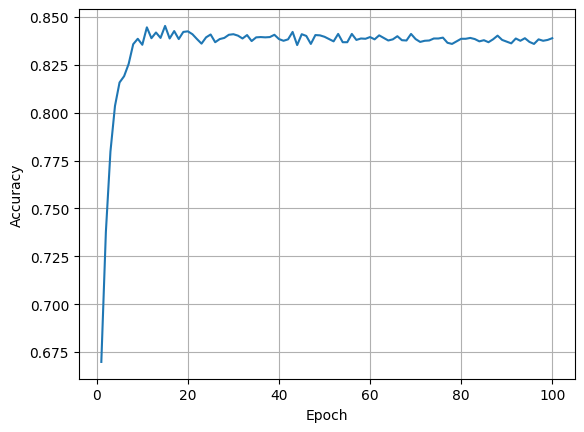

In [10]:
# 绘图
epoch = np.arange(1,len(acc_list)+1,1)
acc_list = np.array(acc_list)
plt.plot(epoch,acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()